# This script implements a simple baseline-CNN model for the Music Genre Classification task.
It can be used as a Jupyter- or Colab-Notebook.



# Colab-Specific

## Mount GDrive to Colab session

In [0]:
from google.colab import drive
drive.mount('/content/drive')

##  Set path to dataset stored in GDrive
Distinguish between train- and test data. Make sure dataset is added to '***My Drive***'! 

In [0]:
data_storage_path = '/content/drive/My Drive/ML/ML_experiments'
path_train_data_set = '/content/drive/My Drive/ML/dataset_transformed/spectrograms512_train'
path_test_data_set = '/content/drive/My Drive/ML/dataset_transformed/spectrograms512_test'

In [0]:
# Imports mainly for debugging
import IPython.display as display
from PIL import Image
import matplotlib.pyplot as plt

# Imports

Select specific tensorflow setup to make sure it's gonna run on GPU

In [15]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.0`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
Found GPU at: /device:GPU:0


Remaining imports

In [0]:
# Import os
import os

# Imports tensorflow
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import pathlib  # For data generators 

# Imports image handling
import numpy as np

# Save training progress
import csv
from datetime import datetime

# Set up folder for data gathering during training process

In [0]:
# Set up folder for data gathering during training process
now = datetime.now()
TIME_STAMP = now.strftime("_%Y_%d_%m__%H_%M_%S__%f")
MODEL_ID = 'Model_' + TIME_STAMP
training_path = data_storage_path + '/Trained_Models/CNN_Models/'
path = training_path + MODEL_ID + '/'

if not os.path.exists(path):
    os.makedirs(path)
    print('Created dir: ' + path)
else:
    path = None
    raise Exception('PATH EXISTS!')

# Set up the CNN architecture & helpers

## Define Model Architecture

In [0]:
# Reset tf sessions
tf.keras.backend.clear_session()  # Destroys the current TF graph and creates a new one.
 
dimensions = 512 # Image-Dimension: 512x512x1 (BW-image)
classes = 10
 
# Set up model architecture in terms of its layers
model = models.Sequential()
 
# Set layers
model.add(layers.Conv2D(64, (3, 3), activation='relu', strides=1, input_shape=(dimensions, dimensions, 1), # 32 batch size
                                                       kernel_regularizer=regularizers.l2(0.001)
          ))
model.add(layers.Conv2D(64, (3, 3), activation='relu', strides=2, kernel_regularizer=regularizers.l2(0.001)  
          ))
model.add(layers.Conv2D(32, (3, 3), activation='relu', strides=2, kernel_regularizer=regularizers.l2(0.001)
          ))
model.add(layers.Conv2D(4, (5, 5), activation='relu', strides=3, kernel_regularizer=regularizers.l2(0.001)
          ))
model.add(layers.Conv2D(4, (3, 3), activation='relu', strides=2, kernel_regularizer=regularizers.l2(0.001)
          ))
model.add(layers.Conv2D(8, (3, 3), activation='relu', strides=2, kernel_regularizer=regularizers.l2(0.001)
          ))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0000001)
          ))
model.add(layers.Dense(classes, activation='softmax'))
 
# Note on regularizer(s), copied from https://www.tensorflow.org/tutorials/keras/overfit_and_underfit:
# l2(0.001) means that every coefficient in the weight matrix of the layer will add 0.001 * weight_coefficient_value**2
# to the total loss of the network.
#model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Dropout(0.05))
 
# Print summary
model.summary()
 
# Compile model & make some design choices
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001,
                                           beta_1=0.9,
                                           beta_2=0.999,
                                           epsilon=1e-07,
                                           amsgrad=False,
                                           name='Adam'
                                           ),
              loss='sparse_categorical_crossentropy',  # Capable of working with regularization
              metrics=['accuracy', 'sparse_categorical_crossentropy'])



## Define Callbacks

In [0]:
# Definition of callbacks adjusted from https://www.tensorflow.org/guide/keras/train_and_evaluate

early_stopping_callback = EarlyStopping(
        monitor='val_accuracy',    # Stop training when `val_loss` is no longer improving
        min_delta=0,               # "no longer improving" being defined as "no better than 0|5e-1 less"
        patience=2,                # "no longer improving" being further defined as "for at least 2 epochs"
        verbose=0)                 # Quantity of printed output

model_saving_callback = ModelCheckpoint(
        filepath=path+'cnn_model.h5',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        # mode: one of {auto, min, max}. If `save_best_only=True`, the decision to
        # overwrite the current save file is made based on either the maximization
        # or the minimization of the monitored quantity. For `val_acc`, this
        # should be `max`, for `val_loss` this should be `min`, etc. In `auto`
        # mode, the direction is automatically inferred from the name of the
        # monitored quantity.
        verbose=0)

# Join list of required callbacks
callbacks = [model_saving_callback] # Outtake: early_stopping_callback

## Define Data Generator & associated (optional) pre-processing method

Pre-Processing

In [0]:
def preprocessing_function(x):
    """
    Could be used for rotating image in RNN, for example. Not in use, rn.
    """
    #assert x.shape == (512, 512, 1)
    return x



## Training data generator

In [0]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, 
                                                     #preprocessing_function=preprocessing_function  # Pre-processing function may be passed here
                                                     )

BATCH_SIZE = 32
IMG_HEIGHT = 512
IMG_WIDTH = 512
STEPS_PER_EPOCH = 25
data_dir = path_train_data_set
data_dir = pathlib.Path(data_dir)

CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])


train_data_gen = train_image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     color_mode='grayscale',  # Make sure that BW images are read in (indeed) as BW
                                                     class_mode='sparse', # Class represented by 1 integer (instead of categorical==1-hot-encoding)
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

## Test|Evaluation data generator

In [0]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, 
                                                     #preprocessing_function=preprocessing_function
                                                     )

BATCH_SIZE = 32
IMG_HEIGHT = 512
IMG_WIDTH = 512
STEPS_PER_EPOCH = 25 #np.ceil(image_count/BATCH_SIZE)
data_dir = path_test_data_set
data_dir = pathlib.Path(data_dir)


CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])


test_data_gen = test_image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     color_mode='grayscale',
                                                     class_mode='sparse',
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

# Test data imports  (train) generator

### Helper function

In [0]:
def show_batch(image_batch, label_batch):
  print('Batch dimensions: ' + str(image_batch.shape))
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      image = image_batch[n]
      # If grayscale, repeat 1 channel 3 times for visualization
      if image.shape[2] == 1:
        image = np.repeat(image, 3, axis=2)
      plt.imshow(image)
      plt.title(CLASS_NAMES[int(label_batch[n])].title())  # Doesn't work anymore after change of label encoding from 1-hot to spare
      plt.axis('off')


### Visualize generated example batch and labels


Batch dimensions: (32, 512, 512, 1)


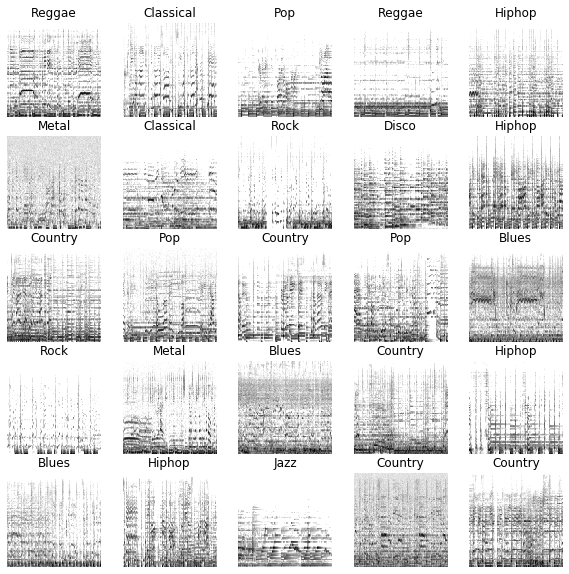

In [13]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

# Perform training

'accuracy' == accuracy achieved during training on training data

'val_accuracy' == accuracy achieved on Test/Evaluation data

In [0]:
assert tf.config.list_physical_devices('GPU')
assert tf.test.is_built_with_cuda()

# Set number of desired epochs
epochs = 100

# Perform x epochs of training
with tf.device('/device:GPU:0'):
  history = model.fit(
      x=train_data_gen,
      #y=None,
      #batch_size=None,
      epochs=epochs,
      verbose=1,
      callbacks=callbacks,
      #validation_split=0.0,
      validation_data=test_data_gen,
      shuffle=True,
      #class_weight=None,
      #sample_weight=None,
      initial_epoch=0,
      steps_per_epoch=25,
      validation_steps=18,
      #validation_freq=1,
      max_queue_size=2,
      #workers=1,
      #use_multiprocessing=False,
      #**kwargs
  )

# Save the entire model as a final model to a HDF5 file.
name = 'final_model'
model.save(path+name+'.h5')

# Record training progress
with open(path+'training_progress.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["epoch", "loss", "accuracy", "val_loss", "val_accuracy", "sparse_categorical_crossentropy"])
    for line in range(len(history.history['loss'])): 
        epoch = str(line+1)
        writer.writerow([epoch,
                         history.history["loss"][line], 
                         history.history["accuracy"][line], 
                         history.history["val_loss"][line], 
                         history.history["val_accuracy"][line], 
                         history.history["sparse_categorical_crossentropy"][line]
                         ])
    # Save some more important bits/summary
    writer.writerow(["End of training. Summary:"])
    writer.writerow(["epoch", "loss", "accuracy", "val_loss", "val_accuracy", "sparse_categorical_crossentropy"])
    # Max accuracy
    writer.writerow(["Max accuracy row:"])
    x = np.argmax(history.history["accuracy"])
    writer.writerow([str(x+1),
                         history.history["loss"][x], 
                         history.history["accuracy"][x], 
                         history.history["val_loss"][x], 
                         history.history["val_accuracy"][x], 
                         history.history["sparse_categorical_crossentropy"][x]
                         ])
    # Max val_accuracy
    writer.writerow(["Max val_accuracy row:"])
    x = np.argmax(history.history["val_accuracy"])
    writer.writerow([str(x+1),
                         history.history["loss"][x], 
                         history.history["accuracy"][x], 
                         history.history["val_loss"][x], 
                         history.history["val_accuracy"][x], 
                         history.history["sparse_categorical_crossentropy"][x]
                         ])
    file.close()

print('Done.')